## Import of library

In [ ]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A
import requests
from io import BytesIO

from PIL import Image

import random
import torch

from tqdm.notebook import tqdm

import torch.nn as nn

from torch._C import device

import torch.optim as optim

import torch.autograd.grad_mode as grad_mode

from torch.autograd import Function as F

from torch.utils.data import DataLoader, Dataset

import torchvision 

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.rpn import AnchorGenerator

C:\Users\T0317216\AppData\Local\Temp\ipykernel_12768\1039351594.py:5: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.defchararray.join.
  from numpy.core.defchararray import join, mod
C:\Users\T0317216\AppData\Local\Temp\ipykernel_12768\1039351594.py:5: DeprecationWarning: numpy.core.defchararray is deprecated and has been renamed to numpy._core.defchararray. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most r

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using device:", device)

Using device: cpu


In [3]:
def imgshow(number, title=None, size=5):
    root = "../artifacts/raw/"
    image = cv2.imread(root + "Images/" + str(number) + ".jpeg")
    #print(image.shape)
    #print(image.dtype)
    #print(image[:, :, 0])
    file = open(root + "Labels/" + str(number) + ".txt", "r")
    txt_data = file.readlines()
    file.close()
    #print(txt_data)

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])
    
        cv2.rectangle(image, start_point, end_point, (0, 0, 255), 2)

    aspect_ratio = image.shape[0] / image.shape[1] # hight / width

    plt.figure(figsize=(size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title+txt_data[0])
    plt.axis('off')
    plt.show()

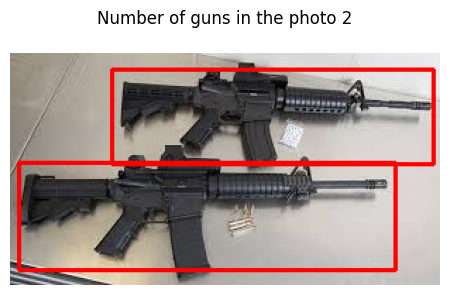

In [4]:
imgshow(119, "Number of guns in the photo ", size=5)

In [19]:
class Gun_Data(Dataset):

    def __init__(self, root):
        self.image_path = root + "Images/"
        self.label_path = root + "Labels/"


        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.label_path))]

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        img_res = img_rgb / 255.0 # normalize the image
        img_res = torch.as_tensor(img_res).permute(2, 0, 1) # convert to tensor and change the order of dimensions

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.label_path, label_name)

        #print("Label path:", label_path)

        with open(label_path, "r") as file:
            l_count = int(file.readline())
            box = []
            for i in range(l_count):
                indices = [int(x) for x in file.readline().split()]
                box.append(indices)  

        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.tensor(idx)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)

        return img_res, target
    
    def __len__(self):
        return len(self.img_name)

In [6]:
num_epoch = 30

In [7]:
class Model:
    
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)

        in_features = model.roi_heads.box_predictor.cls_score.in_features

        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)

        return model
    
    def compiler(self, optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)

            train_loss = 0
            self.model.train()

            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())

                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()

                train_loss += loss
            print(f"Epoch : {epoch + 1} | Train Loss : {train_loss}")

In [8]:
from torch.utils.data import random_split

In [27]:
rcnn = Model(2)

model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_Data("../artifacts/raw/")

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)

c:\Users\T0317216\Documents\training\Beginner_Advanced_MLOps\Guns_detection\Code\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\T0317216\Documents\training\Beginner_Advanced_MLOps\Guns_detection\Code\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
rcnn.train(train_loader, val_loader)

In [ ]:
def test(data, number=random.randint(1, 334)):
    img, target = data[number]

    model.eval() #disable dropout and batch normalization
    with torch.no_grad():
        predictions = model([img])

    predictions = [{k:v.to(device) for k, v in t.items()} for t in predictions]


    return predictions, target, img

In [29]:
def apply_nms(orig_predictions, iou_threshold=None):
    keep = torchvision.ops.nms(orig_predictions['boxes'], orig_predictions['scores'], iou_threshold)

    final_predictions = orig_predictions
    final_predictions['boxes'] = final_predictions["boxes"][keep]
    final_predictions['scores'] = final_predictions["scores"][keep]
    final_predictions['labels'] = final_predictions["labels"][keep]

    return final_predictions

In [45]:
from torchvision import transforms as torchtrans

In [46]:
def torch_to_pil(image_tensor):
    return torchtrans.ToPILImage()(image_tensor).convert("RGB")

In [31]:
def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target['boxes']:
        x,y,width,height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+height)), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0] / img_cv.shape[1] # height / width

    plt.figure(figsize=(size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

In [34]:
predictions, target, img = test(dataset, number=10)

In [39]:
nms_prediction = apply_nms(predictions[0], iou_threshold=0.7)

In [52]:
nms_prediction

{'boxes': tensor([[1.5634e+02, 1.0789e+02, 1.6629e+02, 1.4707e+02],
         [1.5027e+02, 1.1581e+02, 1.6304e+02, 1.5068e+02],
         [1.2629e+02, 1.0302e+02, 1.8020e+02, 1.6767e+02],
         [1.4855e+02, 1.0234e+02, 1.6676e+02, 1.5479e+02],
         [1.2600e+02, 8.5402e+01, 1.4450e+02, 1.2298e+02],
         [1.0818e+02, 8.6269e+01, 1.4712e+02, 1.2573e+02],
         [8.8830e+01, 7.4605e+01, 1.4158e+02, 1.8576e+02],
         [1.4307e+02, 1.1609e+02, 1.5394e+02, 1.5246e+02],
         [1.5311e+02, 1.0953e+02, 1.8420e+02, 1.4855e+02],
         [1.3983e+02, 7.2201e+01, 1.6023e+02, 1.2118e+02],
         [1.6048e+02, 9.0231e+01, 1.8037e+02, 1.5233e+02],
         [1.0964e+02, 8.1357e+01, 1.2872e+02, 9.8682e+01],
         [1.2041e+02, 2.2977e+00, 1.6286e+02, 8.6249e+01],
         [1.5310e+02, 8.1258e+01, 1.7168e+02, 1.4655e+02],
         [1.0455e+02, 4.0382e+01, 1.5181e+02, 1.3239e+02],
         [1.0281e+02, 9.2031e+01, 1.3198e+02, 1.2652e+02],
         [1.4604e+02, 7.8872e+01, 1.6418e+02, 1

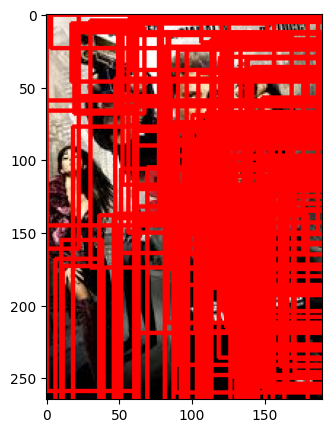

In [47]:
plot_img_bbox(torch_to_pil(img), nms_prediction)

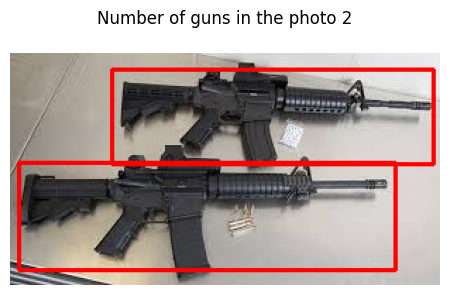

In [48]:
imgshow(119, "Number of guns in the photo ", size=5)